# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    #DETECTION_MIN_CONFIDENCE = 0.2
    #RPN_NMS_THRESHOLD = 0.2 # New

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


## Run Object Detection

Processing 1 images
image                    shape: (2992, 5152, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 3008, 5184, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 5184.00000  int64
anchors                  shape: (1, 3894561, 4)       min:   -0.12040  max:    1.09912  float32


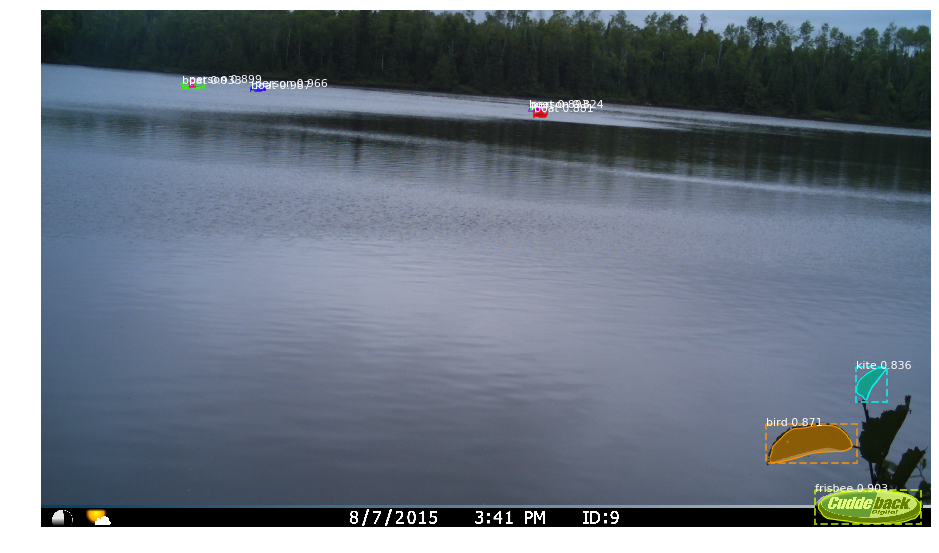

In [7]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('/home/ubuntu/data/L__00010.JPG')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Count features and add to pandas dataframe

In [5]:
import pandas as pd
import glob, time

jpgs = sorted(glob.glob(os.path.join('/home/ubuntu/data/LeoEast', '*.JPG')))
out_csv = r'/home/ubuntu/data/csv/results-7-11-2019.csv'

counter = 1
data = []
for jpg in jpgs:
    start = time.time()
    image = skimage.io.imread(jpg)
    
    # Run detection
    results = model.detect([image], verbose=0) # switch to verbose = 1 for image info
    
    # Count features
    vals = [item for item in list(results[0].get('class_ids')) if str(item) in ['1','9']]
    print('There are {0} watercraft and {1} boat anglers in image {2}'.format(vals.count(9), vals.count(1), os.path.basename(jpg)))

    # Visualize results
    #r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #                            class_names, r['scores'])
    
    # Add results to pandas dataframe
    data.append({'image_path':os.path.basename(jpg), 'watercraft':vals.count(9), 'boat_anglers':vals.count(1)})
    
    # Keep a verbose tally on where we are at on the processing
    end = time.time()
    print('{0}: {1} of {2} processed in {3} seconds'.format(os.path.basename(jpg), counter, len(jpgs), round(end - start, 2)))
    print('----------------------------------------')
    counter += 1
    
df = pd.DataFrame(data, columns = ['image_path', 'watercraft', 'boat_anglers'])
df

# Save pandas dataframe to csv
df.to_csv(out_csv, encoding='utf-8', index=False)

print("Processing complete")


There are 0 watercraft and 0 boat anglers in image LeoEast0001.JPG
LeoEast0001.JPG: 1 of 2516 processed in 114.4 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0002.JPG
LeoEast0002.JPG: 2 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0003.JPG
LeoEast0003.JPG: 3 of 2516 processed in 8.72 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0004.JPG
LeoEast0004.JPG: 4 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0005.JPG
LeoEast0005.JPG: 5 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0006.JPG
LeoEast0006.JPG: 6 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat

There are 0 watercraft and 0 boat anglers in image LeoEast0052.JPG
LeoEast0052.JPG: 52 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0053.JPG
LeoEast0053.JPG: 53 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0054.JPG
LeoEast0054.JPG: 54 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0055.JPG
LeoEast0055.JPG: 55 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0056.JPG
LeoEast0056.JPG: 56 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0057.JPG
LeoEast0057.JPG: 57 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0

There are 0 watercraft and 1 boat anglers in image LeoEast0103.JPG
LeoEast0103.JPG: 103 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0104.JPG
LeoEast0104.JPG: 104 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0105.JPG
LeoEast0105.JPG: 105 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0106.JPG
LeoEast0106.JPG: 106 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast0107.JPG
LeoEast0107.JPG: 107 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0108.JPG
LeoEast0108.JPG: 108 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0154.JPG
LeoEast0154.JPG: 154 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0155.JPG
LeoEast0155.JPG: 155 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0156.JPG
LeoEast0156.JPG: 156 of 2516 processed in 8.54 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0157.JPG
LeoEast0157.JPG: 157 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0158.JPG
LeoEast0158.JPG: 158 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0159.JPG
LeoEast0159.JPG: 159 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0205.JPG
LeoEast0205.JPG: 205 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0206.JPG
LeoEast0206.JPG: 206 of 2516 processed in 8.61 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast0207.JPG
LeoEast0207.JPG: 207 of 2516 processed in 8.69 seconds
----------------------------------------
There are 1 watercraft and 3 boat anglers in image LeoEast0208.JPG
LeoEast0208.JPG: 208 of 2516 processed in 8.88 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast0209.JPG
LeoEast0209.JPG: 209 of 2516 processed in 8.92 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0210.JPG
LeoEast0210.JPG: 210 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0256.JPG
LeoEast0256.JPG: 256 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0257.JPG
LeoEast0257.JPG: 257 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0258.JPG
LeoEast0258.JPG: 258 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0259.JPG
LeoEast0259.JPG: 259 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0260.JPG
LeoEast0260.JPG: 260 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0261.JPG
LeoEast0261.JPG: 261 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft a

There are 0 watercraft and 0 boat anglers in image LeoEast0307.JPG
LeoEast0307.JPG: 307 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0308.JPG
LeoEast0308.JPG: 308 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0309.JPG
LeoEast0309.JPG: 309 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0310.JPG
LeoEast0310.JPG: 310 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0311.JPG
LeoEast0311.JPG: 311 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0312.JPG
LeoEast0312.JPG: 312 of 2516 processed in 8.51 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0358.JPG
LeoEast0358.JPG: 358 of 2516 processed in 8.72 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0359.JPG
LeoEast0359.JPG: 359 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0360.JPG
LeoEast0360.JPG: 360 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0361.JPG
LeoEast0361.JPG: 361 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0362.JPG
LeoEast0362.JPG: 362 of 2516 processed in 8.72 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0363.JPG
LeoEast0363.JPG: 363 of 2516 processed in 8.79 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0409.JPG
LeoEast0409.JPG: 409 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0410.JPG
LeoEast0410.JPG: 410 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0411.JPG
LeoEast0411.JPG: 411 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0412.JPG
LeoEast0412.JPG: 412 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0413.JPG
LeoEast0413.JPG: 413 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0414.JPG
LeoEast0414.JPG: 414 of 2516 processed in 8.74 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0460.JPG
LeoEast0460.JPG: 460 of 2516 processed in 8.73 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0461.JPG
LeoEast0461.JPG: 461 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0462.JPG
LeoEast0462.JPG: 462 of 2516 processed in 8.74 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0463.JPG
LeoEast0463.JPG: 463 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0464.JPG
LeoEast0464.JPG: 464 of 2516 processed in 8.74 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0465.JPG
LeoEast0465.JPG: 465 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0511.JPG
LeoEast0511.JPG: 511 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0512.JPG
LeoEast0512.JPG: 512 of 2516 processed in 8.55 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0513.JPG
LeoEast0513.JPG: 513 of 2516 processed in 8.55 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0514.JPG
LeoEast0514.JPG: 514 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0515.JPG
LeoEast0515.JPG: 515 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0516.JPG
LeoEast0516.JPG: 516 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0562.JPG
LeoEast0562.JPG: 562 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0563.JPG
LeoEast0563.JPG: 563 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0564.JPG
LeoEast0564.JPG: 564 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0565.JPG
LeoEast0565.JPG: 565 of 2516 processed in 8.54 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast0566.JPG
LeoEast0566.JPG: 566 of 2516 processed in 8.64 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast0567.JPG
LeoEast0567.JPG: 567 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0613.JPG
LeoEast0613.JPG: 613 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0614.JPG
LeoEast0614.JPG: 614 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0615.JPG
LeoEast0615.JPG: 615 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0616.JPG
LeoEast0616.JPG: 616 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0617.JPG
LeoEast0617.JPG: 617 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0618.JPG
LeoEast0618.JPG: 618 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0664.JPG
LeoEast0664.JPG: 664 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0665.JPG
LeoEast0665.JPG: 665 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0666.JPG
LeoEast0666.JPG: 666 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast0667.JPG
LeoEast0667.JPG: 667 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0668.JPG
LeoEast0668.JPG: 668 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0669.JPG
LeoEast0669.JPG: 669 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0715.JPG
LeoEast0715.JPG: 715 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0716.JPG
LeoEast0716.JPG: 716 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0717.JPG
LeoEast0717.JPG: 717 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0718.JPG
LeoEast0718.JPG: 718 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0719.JPG
LeoEast0719.JPG: 719 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0720.JPG
LeoEast0720.JPG: 720 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0766.JPG
LeoEast0766.JPG: 766 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0767.JPG
LeoEast0767.JPG: 767 of 2516 processed in 8.62 seconds
----------------------------------------
There are 1 watercraft and 1 boat anglers in image LeoEast0768.JPG
LeoEast0768.JPG: 768 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0769.JPG
LeoEast0769.JPG: 769 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0770.JPG
LeoEast0770.JPG: 770 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0771.JPG
LeoEast0771.JPG: 771 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0817.JPG
LeoEast0817.JPG: 817 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0818.JPG
LeoEast0818.JPG: 818 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0819.JPG
LeoEast0819.JPG: 819 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0820.JPG
LeoEast0820.JPG: 820 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0821.JPG
LeoEast0821.JPG: 821 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0822.JPG
LeoEast0822.JPG: 822 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0868.JPG
LeoEast0868.JPG: 868 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0869.JPG
LeoEast0869.JPG: 869 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0870.JPG
LeoEast0870.JPG: 870 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0871.JPG
LeoEast0871.JPG: 871 of 2516 processed in 8.72 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0872.JPG
LeoEast0872.JPG: 872 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0873.JPG
LeoEast0873.JPG: 873 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft

There are 0 watercraft and 0 boat anglers in image LeoEast0919.JPG
LeoEast0919.JPG: 919 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0920.JPG
LeoEast0920.JPG: 920 of 2516 processed in 8.8 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0921.JPG
LeoEast0921.JPG: 921 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0922.JPG
LeoEast0922.JPG: 922 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0923.JPG
LeoEast0923.JPG: 923 of 2516 processed in 8.76 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0924.JPG
LeoEast0924.JPG: 924 of 2516 processed in 8.74 seconds
----------------------------------------
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers in image LeoEast0970.JPG
LeoEast0970.JPG: 970 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0971.JPG
LeoEast0971.JPG: 971 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0972.JPG
LeoEast0972.JPG: 972 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0973.JPG
LeoEast0973.JPG: 973 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast0974.JPG
LeoEast0974.JPG: 974 of 2516 processed in 8.7 seconds
----------------------------------------
There are 1 watercraft and 1 boat anglers in image LeoEast0975.JPG
LeoEast0975.JPG: 975 of 2516 processed in 8.65 seconds
----------------------------------------
There are 1 watercraft a

There are 0 watercraft and 0 boat anglers in image LeoEast1021.JPG
LeoEast1021.JPG: 1021 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1022.JPG
LeoEast1022.JPG: 1022 of 2516 processed in 8.61 seconds
----------------------------------------
There are 1 watercraft and 3 boat anglers in image LeoEast1023.JPG
LeoEast1023.JPG: 1023 of 2516 processed in 8.7 seconds
----------------------------------------
There are 1 watercraft and 4 boat anglers in image LeoEast1024.JPG
LeoEast1024.JPG: 1024 of 2516 processed in 8.91 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1025.JPG
LeoEast1025.JPG: 1025 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1026.JPG
LeoEast1026.JPG: 1026 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 waterc

There are 0 watercraft and 0 boat anglers in image LeoEast1071.JPG
LeoEast1071.JPG: 1071 of 2516 processed in 8.52 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1072.JPG
LeoEast1072.JPG: 1072 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1073.JPG
LeoEast1073.JPG: 1073 of 2516 processed in 8.52 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1074.JPG
LeoEast1074.JPG: 1074 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1075.JPG
LeoEast1075.JPG: 1075 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1076.JPG
LeoEast1076.JPG: 1076 of 2516 processed in 8.51 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1121.JPG
LeoEast1121.JPG: 1121 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1122.JPG
LeoEast1122.JPG: 1122 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1123.JPG
LeoEast1123.JPG: 1123 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1124.JPG
LeoEast1124.JPG: 1124 of 2516 processed in 8.53 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1125.JPG
LeoEast1125.JPG: 1125 of 2516 processed in 8.52 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1126.JPG
LeoEast1126.JPG: 1126 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1171.JPG
LeoEast1171.JPG: 1171 of 2516 processed in 8.64 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1172.JPG
LeoEast1172.JPG: 1172 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1173.JPG
LeoEast1173.JPG: 1173 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1174.JPG
LeoEast1174.JPG: 1174 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1175.JPG
LeoEast1175.JPG: 1175 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1176.JPG
LeoEast1176.JPG: 1176 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1221.JPG
LeoEast1221.JPG: 1221 of 2516 processed in 8.55 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1222.JPG
LeoEast1222.JPG: 1222 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1223.JPG
LeoEast1223.JPG: 1223 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1224.JPG
LeoEast1224.JPG: 1224 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1225.JPG
LeoEast1225.JPG: 1225 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1226.JPG
LeoEast1226.JPG: 1226 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1271.JPG
LeoEast1271.JPG: 1271 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1272.JPG
LeoEast1272.JPG: 1272 of 2516 processed in 8.67 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast1273.JPG
LeoEast1273.JPG: 1273 of 2516 processed in 8.8 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1274.JPG
LeoEast1274.JPG: 1274 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1275.JPG
LeoEast1275.JPG: 1275 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1276.JPG
LeoEast1276.JPG: 1276 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1321.JPG
LeoEast1321.JPG: 1321 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1322.JPG
LeoEast1322.JPG: 1322 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1323.JPG
LeoEast1323.JPG: 1323 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1324.JPG
LeoEast1324.JPG: 1324 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1325.JPG
LeoEast1325.JPG: 1325 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1326.JPG
LeoEast1326.JPG: 1326 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1371.JPG
LeoEast1371.JPG: 1371 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1372.JPG
LeoEast1372.JPG: 1372 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1373.JPG
LeoEast1373.JPG: 1373 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1374.JPG
LeoEast1374.JPG: 1374 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1375.JPG
LeoEast1375.JPG: 1375 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1376.JPG
LeoEast1376.JPG: 1376 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1421.JPG
LeoEast1421.JPG: 1421 of 2516 processed in 8.54 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1422.JPG
LeoEast1422.JPG: 1422 of 2516 processed in 8.52 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1423.JPG
LeoEast1423.JPG: 1423 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1424.JPG
LeoEast1424.JPG: 1424 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1425.JPG
LeoEast1425.JPG: 1425 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1426.JPG
LeoEast1426.JPG: 1426 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1472.JPG
LeoEast1472.JPG: 1472 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast1473.JPG
LeoEast1473.JPG: 1473 of 2516 processed in 8.73 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1474.JPG
LeoEast1474.JPG: 1474 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1475.JPG
LeoEast1475.JPG: 1475 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1476.JPG
LeoEast1476.JPG: 1476 of 2516 processed in 8.74 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1477.JPG
LeoEast1477.JPG: 1477 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1522.JPG
LeoEast1522.JPG: 1522 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1523.JPG
LeoEast1523.JPG: 1523 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1524.JPG
LeoEast1524.JPG: 1524 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1525.JPG
LeoEast1525.JPG: 1525 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1526.JPG
LeoEast1526.JPG: 1526 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1527.JPG
LeoEast1527.JPG: 1527 of 2516 processed in 8.7 seconds
----------------------------------------
There are 0 water

There are 1 watercraft and 0 boat anglers in image LeoEast1572.JPG
LeoEast1572.JPG: 1572 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1573.JPG
LeoEast1573.JPG: 1573 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1574.JPG
LeoEast1574.JPG: 1574 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1575.JPG
LeoEast1575.JPG: 1575 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1576.JPG
LeoEast1576.JPG: 1576 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1577.JPG
LeoEast1577.JPG: 1577 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 waterc

There are 0 watercraft and 0 boat anglers in image LeoEast1622.JPG
LeoEast1622.JPG: 1622 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1623.JPG
LeoEast1623.JPG: 1623 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1624.JPG
LeoEast1624.JPG: 1624 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1625.JPG
LeoEast1625.JPG: 1625 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1626.JPG
LeoEast1626.JPG: 1626 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1627.JPG
LeoEast1627.JPG: 1627 of 2516 processed in 8.73 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1672.JPG
LeoEast1672.JPG: 1672 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1673.JPG
LeoEast1673.JPG: 1673 of 2516 processed in 8.6 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1674.JPG
LeoEast1674.JPG: 1674 of 2516 processed in 8.66 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1675.JPG
LeoEast1675.JPG: 1675 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1676.JPG
LeoEast1676.JPG: 1676 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1677.JPG
LeoEast1677.JPG: 1677 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 0 boat anglers in image LeoEast1722.JPG
LeoEast1722.JPG: 1722 of 2516 processed in 8.52 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1723.JPG
LeoEast1723.JPG: 1723 of 2516 processed in 8.62 seconds
----------------------------------------
There are 1 watercraft and 2 boat anglers in image LeoEast1724.JPG
LeoEast1724.JPG: 1724 of 2516 processed in 8.65 seconds
----------------------------------------
There are 1 watercraft and 3 boat anglers in image LeoEast1725.JPG
LeoEast1725.JPG: 1725 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1726.JPG
LeoEast1726.JPG: 1726 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1727.JPG
LeoEast1727.JPG: 1727 of 2516 processed in 8.54 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1772.JPG
LeoEast1772.JPG: 1772 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1773.JPG
LeoEast1773.JPG: 1773 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1774.JPG
LeoEast1774.JPG: 1774 of 2516 processed in 8.71 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1775.JPG
LeoEast1775.JPG: 1775 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1776.JPG
LeoEast1776.JPG: 1776 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1777.JPG
LeoEast1777.JPG: 1777 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1822.JPG
LeoEast1822.JPG: 1822 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1823.JPG
LeoEast1823.JPG: 1823 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1824.JPG
LeoEast1824.JPG: 1824 of 2516 processed in 8.62 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast1825.JPG
LeoEast1825.JPG: 1825 of 2516 processed in 8.55 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1826.JPG
LeoEast1826.JPG: 1826 of 2516 processed in 8.73 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1827.JPG
LeoEast1827.JPG: 1827 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 wate

There are 2 watercraft and 1 boat anglers in image LeoEast1872.JPG
LeoEast1872.JPG: 1872 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1873.JPG
LeoEast1873.JPG: 1873 of 2516 processed in 8.53 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1874.JPG
LeoEast1874.JPG: 1874 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1875.JPG
LeoEast1875.JPG: 1875 of 2516 processed in 8.53 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1876.JPG
LeoEast1876.JPG: 1876 of 2516 processed in 8.55 seconds
----------------------------------------
There are 1 watercraft and 1 boat anglers in image LeoEast1877.JPG
LeoEast1877.JPG: 1877 of 2516 processed in 8.55 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast1922.JPG
LeoEast1922.JPG: 1922 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1923.JPG
LeoEast1923.JPG: 1923 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1924.JPG
LeoEast1924.JPG: 1924 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1925.JPG
LeoEast1925.JPG: 1925 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1926.JPG
LeoEast1926.JPG: 1926 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1927.JPG
LeoEast1927.JPG: 1927 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 wate

There are 1 watercraft and 0 boat anglers in image LeoEast1972.JPG
LeoEast1972.JPG: 1972 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1973.JPG
LeoEast1973.JPG: 1973 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1974.JPG
LeoEast1974.JPG: 1974 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1975.JPG
LeoEast1975.JPG: 1975 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1976.JPG
LeoEast1976.JPG: 1976 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast1977.JPG
LeoEast1977.JPG: 1977 of 2516 processed in 8.58 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast2022.JPG
LeoEast2022.JPG: 2022 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2023.JPG
LeoEast2023.JPG: 2023 of 2516 processed in 8.64 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2024.JPG
LeoEast2024.JPG: 2024 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2025.JPG
LeoEast2025.JPG: 2025 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2026.JPG
LeoEast2026.JPG: 2026 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2027.JPG
LeoEast2027.JPG: 2027 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast2072.JPG
LeoEast2072.JPG: 2072 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2073.JPG
LeoEast2073.JPG: 2073 of 2516 processed in 8.63 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2074.JPG
LeoEast2074.JPG: 2074 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2075.JPG
LeoEast2075.JPG: 2075 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2076.JPG
LeoEast2076.JPG: 2076 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2077.JPG
LeoEast2077.JPG: 2077 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast2122.JPG
LeoEast2122.JPG: 2122 of 2516 processed in 8.71 seconds
----------------------------------------
There are 2 watercraft and 2 boat anglers in image LeoEast2123.JPG
LeoEast2123.JPG: 2123 of 2516 processed in 8.74 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2124.JPG
LeoEast2124.JPG: 2124 of 2516 processed in 8.64 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2125.JPG
LeoEast2125.JPG: 2125 of 2516 processed in 8.66 seconds
----------------------------------------
There are 2 watercraft and 0 boat anglers in image LeoEast2126.JPG
LeoEast2126.JPG: 2126 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2127.JPG
LeoEast2127.JPG: 2127 of 2516 processed in 8.63 seconds
----------------------------------------
There are 0 wate

There are 1 watercraft and 0 boat anglers in image LeoEast2172.JPG
LeoEast2172.JPG: 2172 of 2516 processed in 8.59 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2173.JPG
LeoEast2173.JPG: 2173 of 2516 processed in 8.62 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2174.JPG
LeoEast2174.JPG: 2174 of 2516 processed in 8.53 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2175.JPG
LeoEast2175.JPG: 2175 of 2516 processed in 8.58 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2176.JPG
LeoEast2176.JPG: 2176 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2177.JPG
LeoEast2177.JPG: 2177 of 2516 processed in 8.55 seconds
----------------------------------------
There are 0 wate

There are 1 watercraft and 0 boat anglers in image LeoEast2222.JPG
LeoEast2222.JPG: 2222 of 2516 processed in 8.63 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2223.JPG
LeoEast2223.JPG: 2223 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2224.JPG
LeoEast2224.JPG: 2224 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2225.JPG
LeoEast2225.JPG: 2225 of 2516 processed in 8.68 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2226.JPG
LeoEast2226.JPG: 2226 of 2516 processed in 8.65 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2227.JPG
LeoEast2227.JPG: 2227 of 2516 processed in 8.57 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast2272.JPG
LeoEast2272.JPG: 2272 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2273.JPG
LeoEast2273.JPG: 2273 of 2516 processed in 8.52 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2274.JPG
LeoEast2274.JPG: 2274 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2275.JPG
LeoEast2275.JPG: 2275 of 2516 processed in 8.62 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2276.JPG
LeoEast2276.JPG: 2276 of 2516 processed in 8.65 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2277.JPG
LeoEast2277.JPG: 2277 of 2516 processed in 8.61 seconds
----------------------------------------
There are 0 wate

There are 0 watercraft and 0 boat anglers in image LeoEast2322.JPG
LeoEast2322.JPG: 2322 of 2516 processed in 8.43 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2323.JPG
LeoEast2323.JPG: 2323 of 2516 processed in 8.44 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2324.JPG
LeoEast2324.JPG: 2324 of 2516 processed in 8.48 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2325.JPG
LeoEast2325.JPG: 2325 of 2516 processed in 8.47 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2326.JPG
LeoEast2326.JPG: 2326 of 2516 processed in 8.45 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2327.JPG
LeoEast2327.JPG: 2327 of 2516 processed in 8.4 seconds
----------------------------------------
There are 1 water

There are 0 watercraft and 0 boat anglers in image LeoEast2372.JPG
LeoEast2372.JPG: 2372 of 2516 processed in 8.37 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2373.JPG
LeoEast2373.JPG: 2373 of 2516 processed in 8.43 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2374.JPG
LeoEast2374.JPG: 2374 of 2516 processed in 8.52 seconds
----------------------------------------
There are 1 watercraft and 0 boat anglers in image LeoEast2375.JPG
LeoEast2375.JPG: 2375 of 2516 processed in 8.5 seconds
----------------------------------------
There are 3 watercraft and 0 boat anglers in image LeoEast2376.JPG
LeoEast2376.JPG: 2376 of 2516 processed in 8.67 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2377.JPG
LeoEast2377.JPG: 2377 of 2516 processed in 8.45 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 1 boat anglers in image LeoEast2422.JPG
LeoEast2422.JPG: 2422 of 2516 processed in 8.4 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2423.JPG
LeoEast2423.JPG: 2423 of 2516 processed in 8.64 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2424.JPG
LeoEast2424.JPG: 2424 of 2516 processed in 8.45 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2425.JPG
LeoEast2425.JPG: 2425 of 2516 processed in 8.56 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2426.JPG
LeoEast2426.JPG: 2426 of 2516 processed in 8.46 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2427.JPG
LeoEast2427.JPG: 2427 of 2516 processed in 8.36 seconds
----------------------------------------
There are 0 water

There are 0 watercraft and 2 boat anglers in image LeoEast2472.JPG
LeoEast2472.JPG: 2472 of 2516 processed in 8.69 seconds
----------------------------------------
There are 0 watercraft and 1 boat anglers in image LeoEast2473.JPG
LeoEast2473.JPG: 2473 of 2516 processed in 8.54 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2474.JPG
LeoEast2474.JPG: 2474 of 2516 processed in 8.5 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2475.JPG
LeoEast2475.JPG: 2475 of 2516 processed in 8.5 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2476.JPG
LeoEast2476.JPG: 2476 of 2516 processed in 8.45 seconds
----------------------------------------
There are 0 watercraft and 0 boat anglers in image LeoEast2477.JPG
LeoEast2477.JPG: 2477 of 2516 processed in 8.33 seconds
----------------------------------------
There are 0 waterc

## Assess the boat count accuracy




In [18]:
from sklearn.metrics import mean_squared_error
import scipy

# Write df to csv for safe keeping
#df.to_csv('/Users/aaron/gdrive/projects/fisheries_census_project/data/outdata/1st_run.csv')

# Read Matt's csv 
df2 = pd.read_csv('/home/ubuntu/data/LeoEast/LeoEast.csv')

# Concatenate dfs
result = pd.concat([df, df2], axis =1)

# Assess accuracy
result['diff'] = result['Watercraft'] - result['watercraft']

# Overall accuracy
overall_accuracy = round(len(result[(result['diff'] == 0)]) / len(result), 2)

# Accuracy for only those images where an object was detected in the real dataset
# Select only rows where true > 0
subset = result[result.Watercraft > 0]
subset_accuracy = round(len(subset[(subset['diff'] == 0)]) / len(subset), 2)

# Accuracy of boat vs non-boat
binary_accuracy = ''

# Calculate MSE for all samples
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
mse = mean_squared_error(result.Watercraft, result.watercraft)

# Calculate MSE for subset

# Confusion matrix
#cm = confusion_matrix(result.Watercraft, result.watercraft)

# Wilcoxon Signed Rank Test using Pratt zero method
# https://stats.stackexchange.com/questions/347930/how-to-consider-pratt-zero-method-in-wilcoxon-test-of-r-which-is-available-in
p = scipy.stats.wilcoxon(result.Watercraft, result.watercraft, zero_method = 'pratt')

# Confusion matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[2175  158   13    1    0]
 [  36   90   17    1    0]
 [   2    5   11    1    0]
 [   1    2    1    1    0]
 [   0    0    0    0    1]]
0.45387105217796553
0.9054054054054054


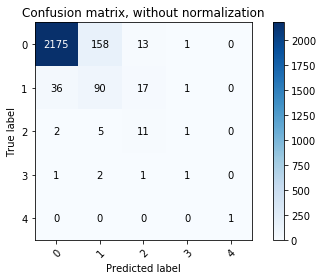

In [19]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = np.array(['0', '1', '2', '3', '4'])
plot_confusion_matrix(result['Watercraft'], result['watercraft'], classes = class_names,
                      title='Confusion matrix, without normalization')

# Calculate Kappa
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(result['Watercraft'], result['watercraft']))

from sklearn.metrics import accuracy_score
print(accuracy_score(result['Watercraft'], result['watercraft']))


In [20]:
print(mse)
print(subset_accuracy) # Note that this is exact--not one or more off
print(overall_accuracy)

0.12241653418124006
0.61
0.91


In [2]:
print(mse)

NameError: name 'mse' is not defined

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


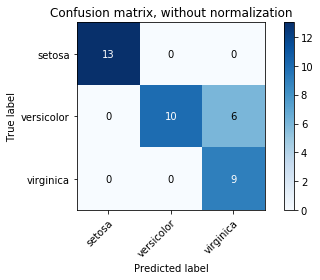

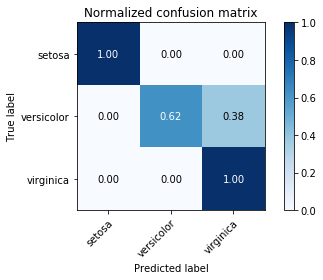

In [22]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:
class_names

In [ ]:
type(class_names)

In [15]:
r

{'rois': array([[ 442, 1217,  463, 1299],
        [ 429, 1239,  453, 1263],
        [ 416,  813,  449,  942],
        [2776, 4480, 2972, 5095],
        [ 410,  857,  441,  891],
        [ 554, 2827,  579, 2892],
        [ 575, 2855,  617, 2933],
        [2396, 4200, 2619, 4727],
        [2063, 4721, 2266, 4900],
        [ 551, 2836,  574, 2862]], dtype=int32),
 'class_ids': array([ 9,  1,  9, 30,  1,  9,  9, 15, 34,  1], dtype=int32),
 'scores': array([0.98657995, 0.96573365, 0.9332341 , 0.903383  , 0.8994495 ,
        0.89292806, 0.88140774, 0.87128586, 0.8356787 , 0.82369345],
       dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, 

In [8]:
r

{'rois': array([[ 442, 1217,  463, 1299],
        [ 429, 1239,  453, 1263],
        [ 416,  813,  449,  942],
        [2776, 4480, 2972, 5095],
        [ 410,  857,  441,  891],
        [ 554, 2827,  579, 2892],
        [ 575, 2855,  617, 2933],
        [2396, 4200, 2619, 4727],
        [2063, 4721, 2266, 4900],
        [ 551, 2836,  574, 2862]], dtype=int32),
 'class_ids': array([ 9,  1,  9, 30,  1,  9,  9, 15, 34,  1], dtype=int32),
 'scores': array([0.98657995, 0.96573365, 0.9332341 , 0.903383  , 0.8994495 ,
        0.89292806, 0.88140774, 0.87128586, 0.8356787 , 0.82369345],
       dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, 